In [1]:
%matplotlib widget
import pandas as pd
import json
from flatten_json import flatten
import math
import matplotlib.pyplot as plt

In [2]:
def parsePlanks(planks):
    return [p["Wheel"] for p in planks]

def parsePassengers(passengers):
    return [[p["Head"], p["Body"]] for p in passengers]

def parseWagons(wagons):
    return [[parsePlanks(w["Wagon"]["Planks"])] + [parsePassengers(w["Passengers"])] for w in wagons]

def parseLocomotive(locomotive):
    return parsePlanks(locomotive["Planks"])
    
def parseTrain(train):
    return [[parseLocomotive(train["Locomotive"])] + w  for w in parseWagons(train["Wagons"])]

def parseTrains(trains):
    x = [parseTrain(t) for t in trains]
    return [[i, j] + w for (i, t) in enumerate(x) for (j, w) in enumerate(t)]

def parseResult(result):
    return [[result["X"]] + r for r in parseTrains(result["Trains"])]

def parseResults(results):
    return [parseResult(r) for r in results]
    

In [3]:
with open('../data/res.json') as data_file:
    data = json.load(data_file)

names = ["X", "TrainId", "WagonId", "LocomotiveWheels", "WagonWheels", "WagonPassengers"]
  
listOfLists = [y for res in parseResults(data["Results"]) for y in res]
trains = pd.DataFrame(listOfLists, columns=names)
trains['#LocomotivePlanks'] = trains['LocomotiveWheels'].apply(len)
trains['#WagonPlanks'] = trains['WagonWheels'].apply(len)
trains['#WagonPassengers'] = trains['WagonPassengers'].apply(len)
trains['#WagonWheels'] = trains['WagonWheels'].apply(lambda wheels: sum(1 for num in wheels if num != 0))
trains['#WagonWheelsSum'] = trains['WagonWheels'].apply(sum)
trains['#WagonPlanks'] = trains['WagonWheels'].apply(len)
Xs = trains.X.unique()

trains.head(5)  



# trains.loc[trains.X == trains.X.unique()[0]].groupby(['TrainId'])[].head()

,X,TrainId,WagonId,LocomotiveWheels,WagonWheels,WagonPassengers,#LocomotivePlanks,#WagonPlanks,#WagonPassengers,#WagonWheels,#WagonWheelsSum
0,0.001,0,0,"[3, 3]","[3, 3]","[[1, 2]]",2,2,1,2,6
1,0.001,0,1,"[3, 3]","[3, 3]","[[1, 2]]",2,2,1,2,6
2,0.001,1,0,"[3, 3]","[3, 3]","[[1, 2]]",2,2,1,2,6
3,0.001,1,1,"[3, 3]","[3, 3]","[[1, 2]]",2,2,1,2,6
4,0.001,2,0,"[3, 3]","[3, 3]","[[1, 2]]",2,2,1,2,6


In [4]:
def chebyshev(data, percent = 0.2):
# Handling cases with insufficient data

    VarX = data.var()
    return math.sqrt(VarX / percent)

def markov(data, percent):
        EX = sum([abs(dat) for dat in data]) / (len(data)- 1)
        return EX / percent

def getUpperAndLower(data, percent):
    sortedData = sorted(data)
    return sortedData[int(percent * len(data))], sortedData[-(int(percent * len(data)) + 1)]

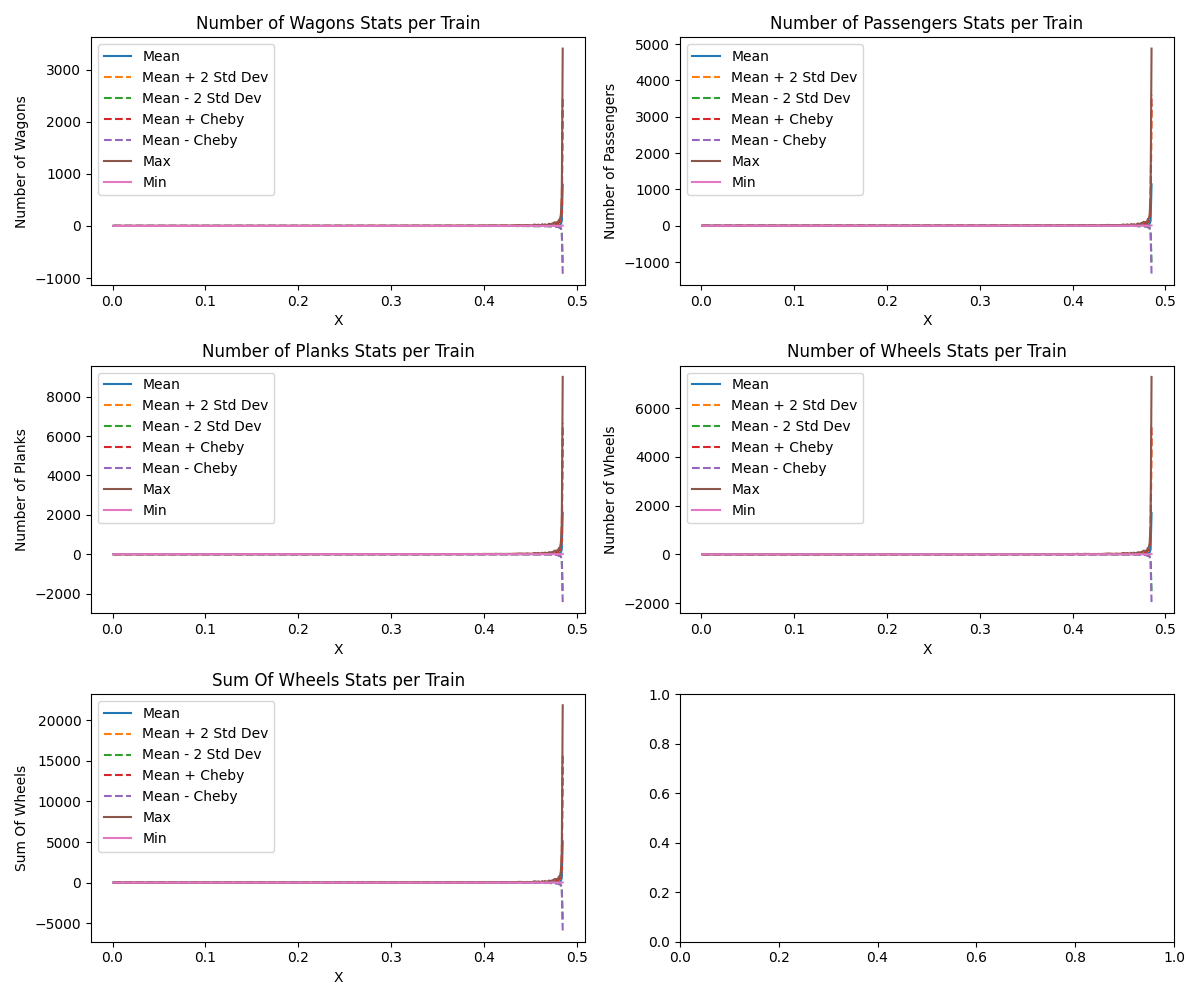

In [5]:
plt.close()
import pandas as pd
import matplotlib.pyplot as plt

# Function to process and plot data
def process_and_plot(df, category, ax, ylabel):
    mean = df[(category, 'mean')]
    std_dev = df[(category, 'std')] * 2
    cheby = df[(category, 'chebyshev')]
    ax.plot(df.index, mean, label='Mean',)
    ax.plot(df.index, mean + std_dev, label='Mean + 2 Std Dev', linestyle='--')
    ax.plot(df.index, mean - std_dev, label='Mean - 2 Std Dev', linestyle='--')
    ax.plot(df.index, mean + cheby, label='Mean + Cheby', linestyle='--')
    ax.plot(df.index, mean - cheby, label='Mean - Cheby', linestyle='--')
    ax.plot(df.index, df[(category, 'max')], label='Max',)
    ax.plot(df.index, df[(category, 'min')], label='Min',)
    ax.set_title(f'{ylabel} Stats per Train')
    ax.set_xlabel('X')
    ax.set_ylabel(ylabel)
    ax.legend()


# Assuming df is your DataFrame

# Group by X and TrainId
grouped = trains.groupby(['X', 'TrainId'])

agg_wagons = grouped['WagonId'].count().reset_index(name='Wagons')
agg_passengers = grouped['#WagonPassengers'].sum().reset_index(name='Passengers')
agg_planks = grouped['#WagonPlanks'].sum().reset_index(name='Planks')
agg_wheels = grouped['#WagonWheels'].sum().reset_index(name='Wheels')
agg_wheels_sum = grouped['#WagonWheelsSum'].sum().reset_index(name='WheelsSum')

agg_data = pd.merge(agg_wagons, agg_passengers, on=['X', 'TrainId'])
agg_data = pd.merge(agg_data, agg_planks, on=['X', 'TrainId'])
agg_data = pd.merge(agg_data, agg_wheels, on=['X', 'TrainId'])
agg_data = pd.merge(agg_data, agg_wheels_sum, on=['X', 'TrainId'])

final_data = agg_data.groupby('X').agg(['mean', 'max', 'min', 'std', chebyshev])

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

for idx, (category, ylabel) in enumerate(zip(['Wagons', 'Passengers', 'Planks', 'Wheels', 'WheelsSum'], 
                                             ['Number of Wagons', 'Number of Passengers', 'Number of Planks', 'Number of Wheels', 'Sum Of Wheels'])):
    process_and_plot(final_data, category, axs[idx//2, idx%2], ylabel)

plt.tight_layout()
plt.show()


       mean  max  min  std  chebyshev
X                                    
0.001   1.0    1    1  0.0        0.0
0.002   1.0    1    1  0.0        0.0
0.003   1.0    1    1  0.0        0.0
0.004   1.0    1    1  0.0        0.0
0.005   1.0    1    1  0.0        0.0


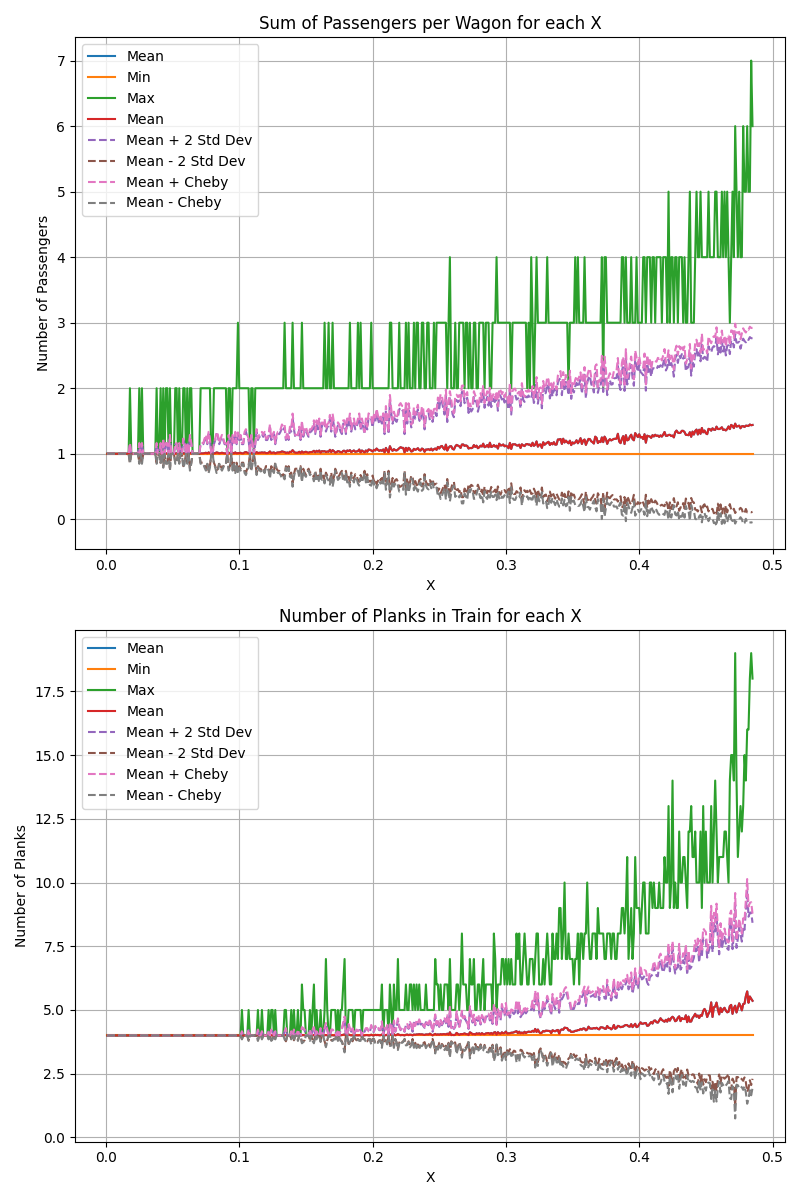

No such comm: 2c5ecbecad7f490485ed2ae5b79f926c


In [6]:
plt.close()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate statistics
def calculate_statistics(trains, column):
    return trains.groupby('X')[column].agg(['mean', 'max', 'min', 'std', chebyshev])

# Function to plot statistics using line plots
def plot_statistics_on_ax(ax, stats, title, y_label):
    mean = stats['mean']
    std_dev = stats['std'] * 2
    cheby = stats['chebyshev']
    ax.plot(stats.index, stats['mean'], label='Mean',)
    ax.plot(stats.index, stats['min'], label='Min',)
    ax.plot(stats.index, stats['max'], label='Max',)

    ax.plot(stats.index, mean, label='Mean',)
    ax.plot(stats.index, mean + std_dev, label='Mean + 2 Std Dev', linestyle='--')
    ax.plot(stats.index, mean - std_dev, label='Mean - 2 Std Dev', linestyle='--')
    ax.plot(stats.index, mean + cheby, label='Mean + Cheby', linestyle='--')
    ax.plot(stats.index, mean - cheby, label='Mean - Cheby', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel(y_label)
    ax.legend()
    ax.grid(True)

# Assuming the dataframe is loaded into a variable named trains
# trains = pd.read_csv('your_file.csv')  # Uncomment and modify this if you need to load the dataframe

# Calculating the sum of passengers in each wagon
trains['SumPassengers'] = trains['#WagonPassengers']

# Calculating statistics for SumPassengers
passenger_stats = calculate_statistics(trains, 'SumPassengers')
print(passenger_stats.head(5))
# Calculating the sum of planks in each train (locomotive + wagon)
trains['TotalPlanks'] = trains['#LocomotivePlanks'] + trains['#WagonPlanks']

# Calculating statistics for TotalPlanks
plank_stats = calculate_statistics(trains, 'TotalPlanks')

# Creating a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Plotting the statistics on the respective axes
plot_statistics_on_ax(ax1, passenger_stats, 'Sum of Passengers per Wagon for each X', 'Number of Passengers')
plot_statistics_on_ax(ax2, plank_stats, 'Number of Planks in Train for each X', 'Number of Planks')

plt.tight_layout()
plt.show()


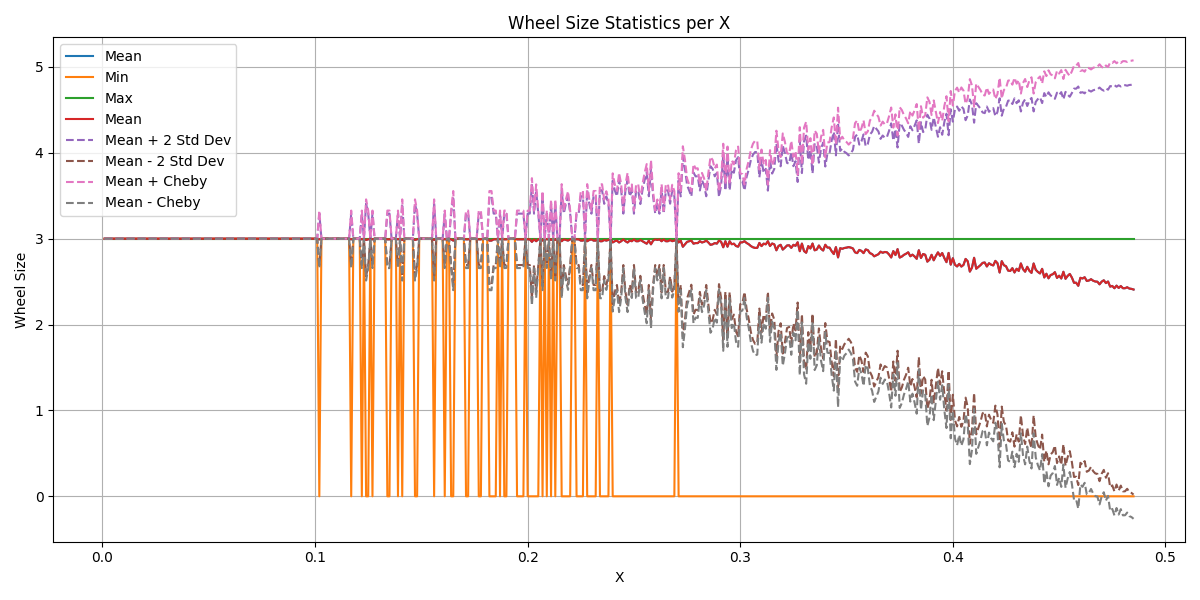

In [7]:
# Assuming the dataframe is loaded into a variable named trains
# df = pd.read_csv('your_file.csv')  # Uncomment and modify this if you need to load the dataframe

# Converting the 'WagonWheels' column to a list of wheel sizes
# Assuming each sublist in 'WagonWheels' contains the sizes of individual wheels
wheel_sizes = trains.explode('WagonWheels')

# Calculating the statistics for wheel sizes
wheel_stats = calculate_statistics(wheel_sizes, 'WagonWheels')

# Creating a figure and axes for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting the statistics for wheel sizes
plot_statistics_on_ax(ax, wheel_stats, 'Wheel Size Statistics per X', 'Wheel Size')

plt.tight_layout()
plt.show()


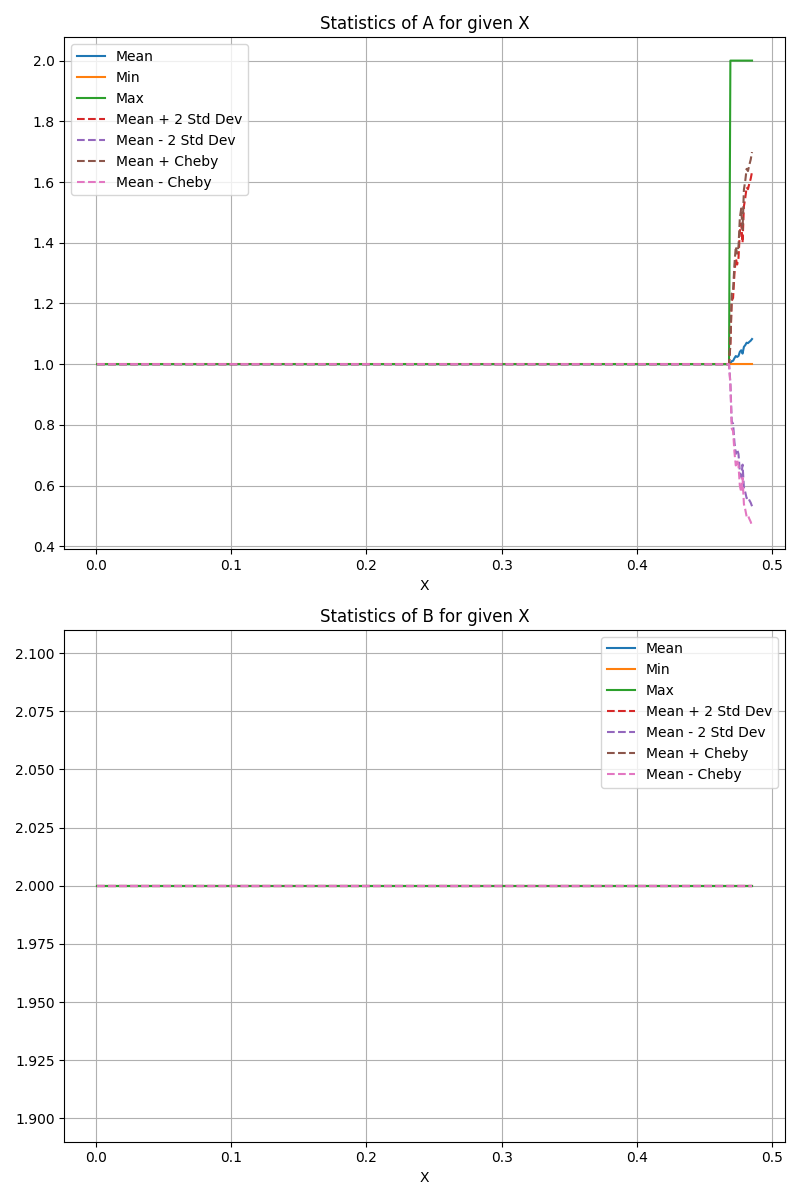

In [8]:
plt.close()
def process_wagon_passengers(df):
    bodies = []
    weights = []

    # Iterating over each row and extracting weight and age
    for _, row in df.iterrows():
        x_value = row['X']
        for passenger in row['WagonPassengers']:
            bodies.append({'X': x_value, 'Body': passenger[0]})
            weights.append({'X': x_value, 'Head': passenger[1]})

    # Creating DataFrames for weight and age
    df_weights = pd.DataFrame(bodies)
    df_ages = pd.DataFrame(weights)

    return df_weights, df_ages

# Function to calculate and plot statistics for a given column
def plot_stats_for_column(ax, df, column, title):
    stats = df.groupby('X')[column].agg(['mean', 'min', 'max', 'std', chebyshev])
    mean = stats['mean']
    std_dev = stats['std'] * 2
    cheby = stats['chebyshev']
    ax.plot(stats.index, stats['mean'], label='Mean',)
    ax.plot(stats.index, stats['min'], label='Min',)
    ax.plot(stats.index, stats['max'], label='Max',)
    ax.plot(stats.index, mean + std_dev, label='Mean + 2 Std Dev', linestyle='--')
    ax.plot(stats.index, mean - std_dev, label='Mean - 2 Std Dev', linestyle='--')
    ax.plot(stats.index, mean + cheby, label='Mean + Cheby', linestyle='--')
    ax.plot(stats.index, mean - cheby, label='Mean - Cheby', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.legend()
    ax.grid(True)

# Process the 'WagonPassengers' column
df_a, df_b = process_wagon_passengers(trains)

fig, axs = plt.subplots(2, figsize=(8, 12))

# Plotting for A
plot_stats_for_column(axs[0], df_a, 'Body', 'Statistics of A for given X')

# Plotting for B
plot_stats_for_column(axs[1], df_b, 'Head', 'Statistics of B for given X')

plt.tight_layout()
plt.show()

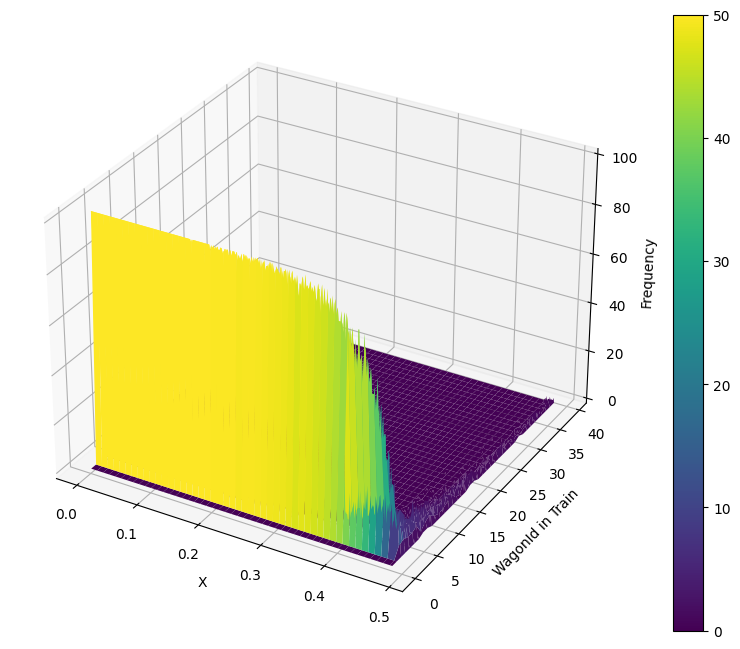

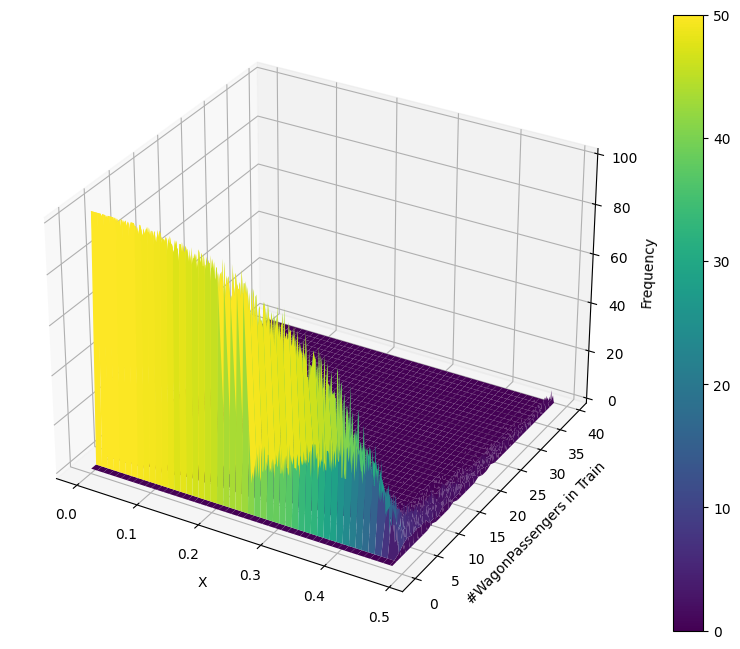

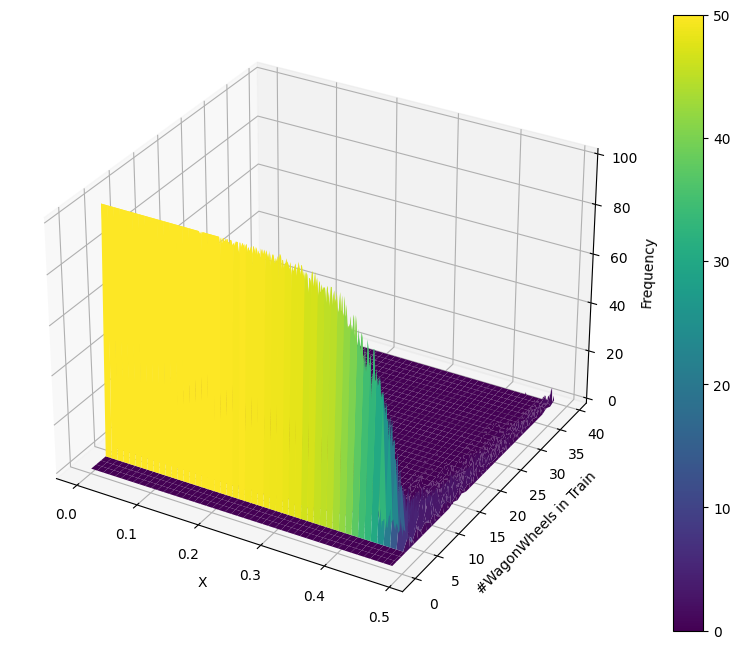

No such comm: d53eb2231c1d4a3d830093792d784232


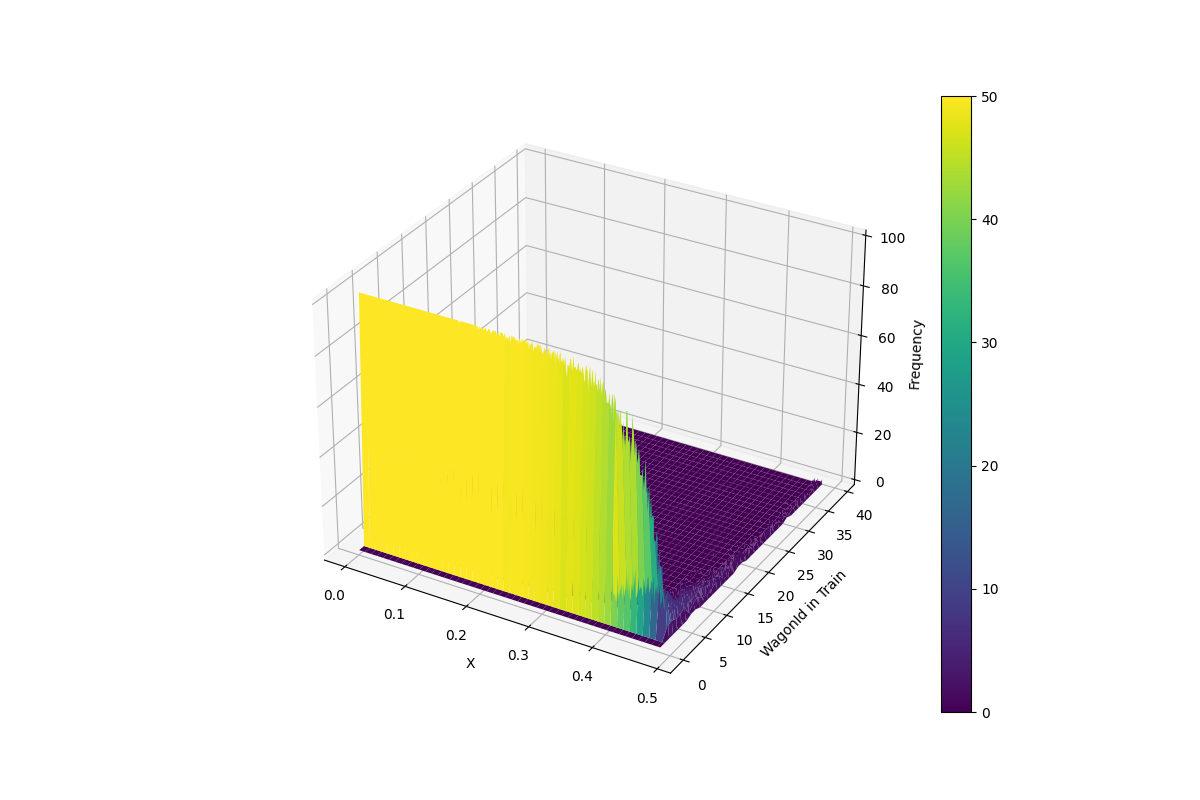

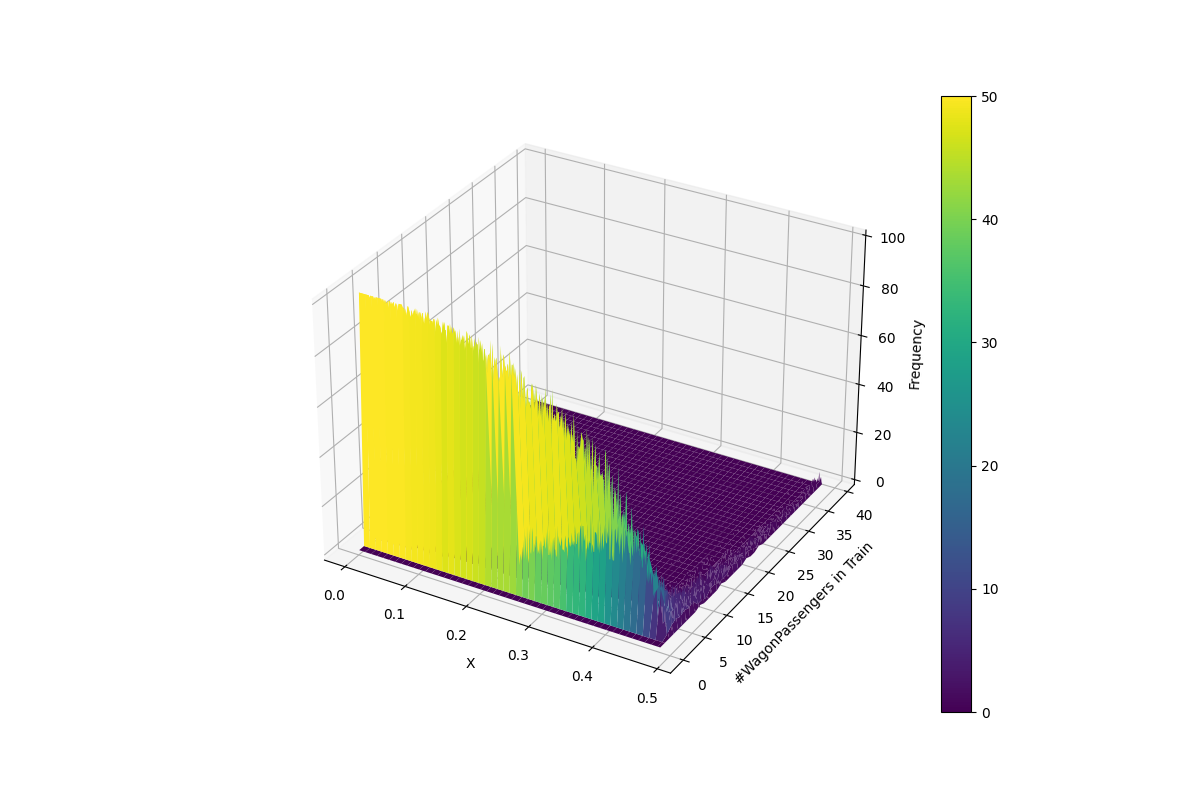

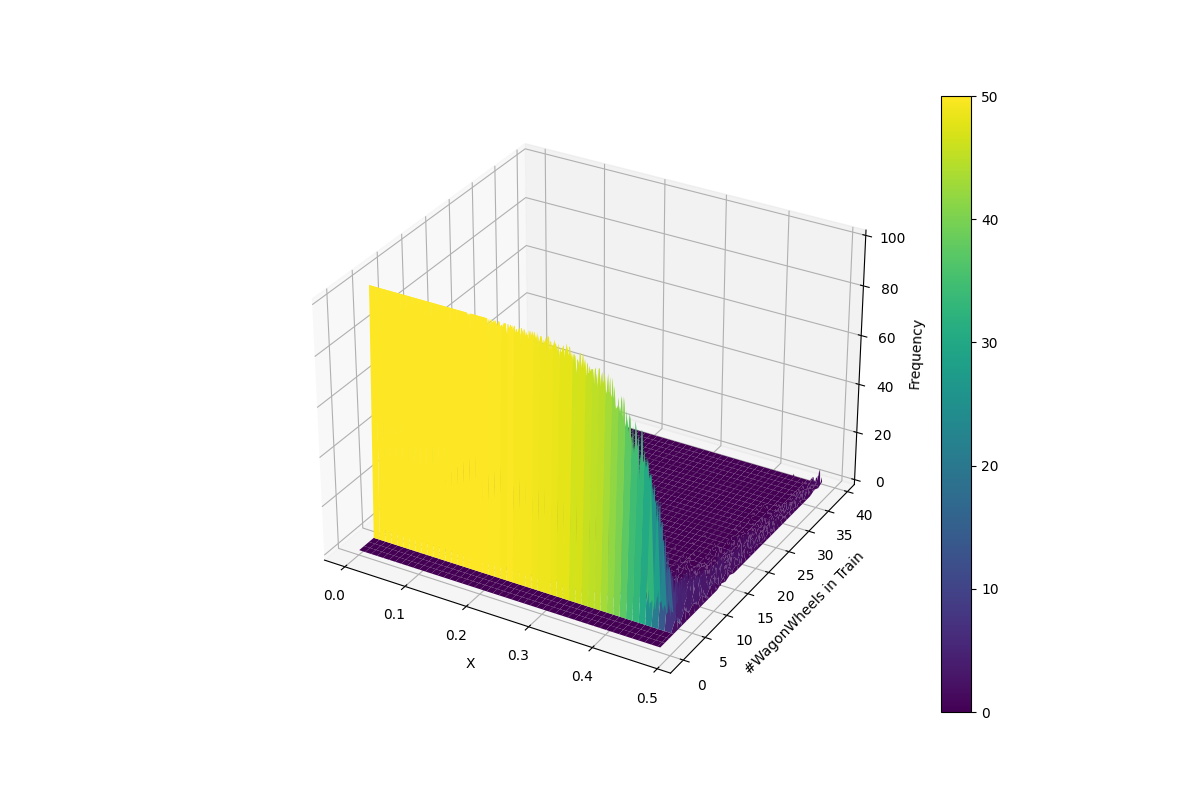

In [9]:
def plotHistogram(label, agg):
    # Assuming df is your DataFrame
    # Calculate the number of wagons in each train for all Xs
    wagon_counts_all = trains.groupby(['X', 'TrainId'])[label].apply(agg)

    # Create a 3D surface plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get unique Xs
    unique_test_ids = trains['X'].unique()

    # Set up variables for 3D surface plot
    hist_data = []
    x_bins = len(unique_test_ids)
    y_bins = 40  # Adjust the number of bins for the number of wagons as needed
    x_range = Xs
    y_range = range(y_bins)

    # Populate the histogram data
    for test_id in unique_test_ids:
        wagon_counts = wagon_counts_all[test_id].values
        hist, _ = np.histogram(wagon_counts, bins=y_bins, range=(0, y_bins))
        hist_data.append(hist)

    # Convert the histogram data to a 2D array
    hist_data = np.array(hist_data)

    # Create X, Y grids
    X, Y = np.meshgrid(x_range, y_range)

    # Plot the 3D surface plot
    surf = ax.plot_surface(X, Y, hist_data.T, cmap='viridis')

    # Customize the labels
    ax.set_xlabel('X')
    ax.set_ylabel(f'{label} in Train')
    ax.set_zlabel('Frequency')

    # Add a colorbar
    fig.colorbar(surf)

    plt.show()
    
plotHistogram("WagonId", lambda x: x.count())
plotHistogram("#WagonPassengers", lambda x: x.sum())
plotHistogram("#WagonWheels", lambda x: x.sum())

# plt.close('all')


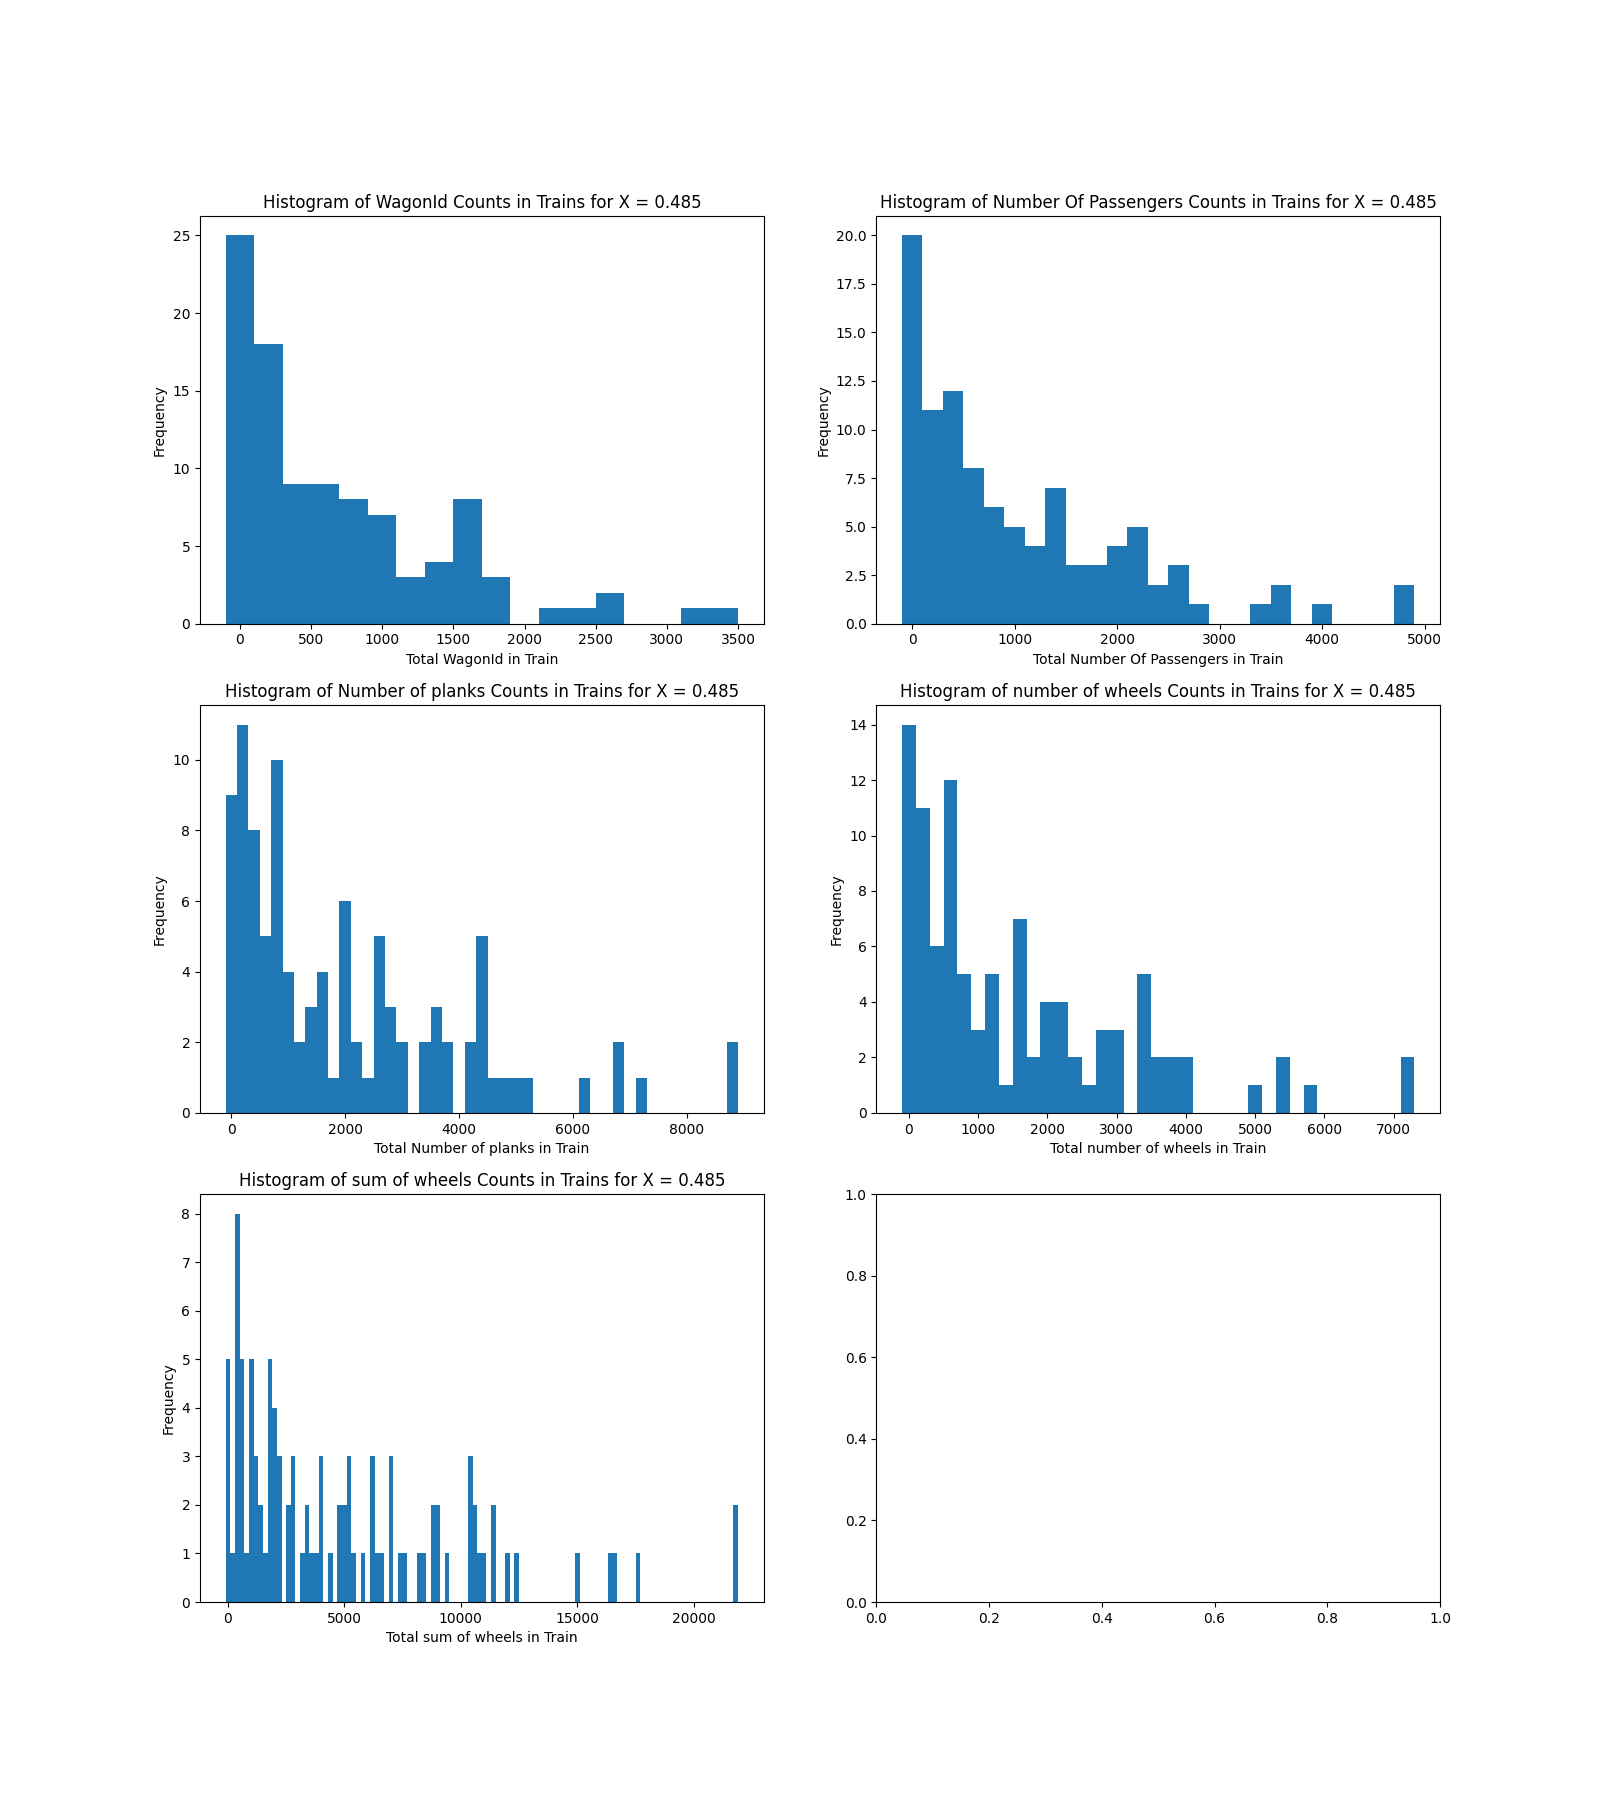

In [10]:
def plot_histogram_for_max_x(df, column, bin_width, title_suffix, agg, ax):
    # Filtering for the maximum value of X
    max_x = df["X"].max()
    max_x_data = df[df["X"] == max_x]

    # Group by TrainId to sum the specified column
    sums = max_x_data.groupby('TrainId')[column].agg(agg)

    # Plotting the histogram
    ax.hist(sums, bins=range(0, sums.max() + bin_width, bin_width), align='left')
    ax.set_xlabel(f'Total {title_suffix} in Train')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {title_suffix} Counts in Trains for X = {round(max_x, 4)}')
    
fig, axs = plt.subplots(3, 2, figsize=(16, 18))

plot_histogram_for_max_x(trains, 'WagonId', 200, 'WagonId', lambda x: x.count(), axs[0][0])
plot_histogram_for_max_x(trains, '#WagonPassengers', 200, 'Number Of Passengers', lambda x: x.sum(), axs[0][1])
plot_histogram_for_max_x(trains, '#WagonPlanks', 200, 'Number of planks', lambda x: x.sum(), axs[1][0])
plot_histogram_for_max_x(trains, '#WagonWheels', 200, 'number of wheels', lambda x: x.sum(), axs[1][1])
plot_histogram_for_max_x(trains, '#WagonWheelsSum', 200, 'sum of wheels', lambda x: x.sum(), axs[2][0])